**'Progression_Model_Combined_PT_FT_logistic' Notebook:**

This notebook explains the process of combining PT and FT progression by applying various transformations, such as joining datasets, updating category mappings, and filling missing values etc. It also involves analyzing correlations and performing encoding based on feature characteristics. The primary objective is to generate a feature importance plot using logistic regression, along with visualizing both local and global explainability.

Purpose: This approach is mainly done to fetch the feature importance plot.

**Installing required libraries**

In [1]:
!pip install pycaret
!pip install scikit-optimize

StatementMeta(, , , Waiting, , Waiting)

**Importing required libraries/modules**

In [2]:
import pycaret
import numpy as np
import pandas as pd
import random
import json
import os
import logging
import cloudpickle
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error,precision_score,roc_auc_score,accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder
import pickle
from datetime import date
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from collections import Counter
from imblearn.combine import SMOTEENN
from datetime import datetime 
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions as F
from lime import lime_tabular 
from lime.lime_tabular import LimeTabularExplainer
from datetime import datetime 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import joblib
import skopt
import shutil
import shap
from enum import Enum
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PolynomialFeatures
from collections import Counter
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions as F
from enum import Enum
import scipy.stats as stats
import pickle
from datetime import datetime
import joblib
import json
from datetime import datetime 
from dateutil.relativedelta import relativedelta
import pandas as pd
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import MapType, StringType

StatementMeta(, , , Waiting, , Waiting)

**Importing progression data from silver layer to do PT analysis**

In [4]:
df_p = spark.sql("SELECT * FROM SilverData.external_progression_data")
df_pt=df_p.toPandas()
df_pt

StatementMeta(, , , Waiting, , Waiting)

,Adult_HE_quintile,Age_group,Disability,Ethnicity,IDACI,IMD,Local_or_distance_learner,Sex,Predicted_outcome_rate,Derived_progression_quintile,createdAt
0,-- Any quintile --,21-25,Cognitive or learning difficulties,Asian or Asian British - Pakistani,-- Any quintile --,-- Any quintile --,Local,Female,0.620000,1,2024-11-25 08:59:18.184056
1,-- Any quintile --,21-25,Cognitive or learning difficulties,Black or black British - African,-- Any quintile --,-- Any quintile --,Local,Female,0.730000,1,2024-11-25 08:59:18.184056
2,-- Any quintile --,21-25,Cognitive or learning difficulties,Black or black British - Caribbean,-- Any quintile --,-- Any quintile --,Local,Female,0.670000,1,2024-11-25 08:59:18.184056
3,-- Any quintile --,21-25,Cognitive or learning difficulties,Mixed - other,-- Any quintile --,-- Any quintile --,Local,Female,0.740000,1,2024-11-25 08:59:18.184056
4,-- Any quintile --,21-25,Cognitive or learning difficulties,Mixed - other,-- Any quintile --,-- Any quintile --,Local,Female,0.740000,1,2024-11-25 08:59:18.184056
...,...,...,...,...,...,...,...,...,...,...,...
770852,-- Any quintile --,-- Any age group --,No disability reported,Asian or Asian British - Indian,-- Any quintile --,-- Any quintile --,Neither,Male,0.820000,3,2024-11-25 08:59:18.184056
770853,-- Any quintile --,-- Any age group --,No disability reported,Asian or Asian British - Indian,-- Any quintile --,-- Any quintile --,Neither,Male,0.820000,3,2024-11-25 08:59:18.184056
770854,-- Any quintile --,-- Any age group --,No disability reported,Asian or Asian British - Indian,-- Any quintile --,-- Any quintile --,Neither,Male,0.820000,3,2024-11-25 08:59:18.184056
770855,-- Any quintile --,-- Any age group --,No disability reported,Asian or Asian British - Indian,-- Any quintile --,-- Any quintile --,Neither,Male,0.820000,3,2024-11-25 08:59:18.184056


**Mapping Any categories as blanks and Local as FT and Distance as PT**

In [5]:
df_pt1 = df_pt.replace({
    '-- Any quintile --':'', 
    '-- Any disability --':'', 
    '-- Any ethnicity --':'', 
    '-- Any quintile --':'', 
    '-- Any learner --': '',
    '-- Any sex --': '',
    'Distance':'PT',
    '-- Any age group --':''  
})

StatementMeta(, , , Waiting, , Waiting)

**Selecting PT combination only**

In [6]:
df_pt1= df_pt1[df_pt1['Local_or_distance_learner']=='PT']
df_pt1

StatementMeta(, , , Waiting, , Waiting)

,Adult_HE_quintile,Age_group,Disability,Ethnicity,IDACI,IMD,Local_or_distance_learner,Sex,Predicted_outcome_rate,Derived_progression_quintile,createdAt
1003,,21-25,Cognitive or learning difficulties,Mixed - white and black African,,,PT,Female,0.750000,1,2024-11-25 08:59:18.184056
1004,Quintile 1,21-25,Cognitive or learning difficulties,,,,PT,Female,0.720000,1,2024-11-25 08:59:18.184056
1005,,21-25,Cognitive or learning difficulties,,Quintile 1,,PT,Female,0.740000,1,2024-11-25 08:59:18.184056
1006,,21-25,Cognitive or learning difficulties,,Quintile 1,,PT,Female,0.740000,1,2024-11-25 08:59:18.184056
1007,,21-25,Cognitive or learning difficulties,,,Quintile 1,PT,Female,0.730000,1,2024-11-25 08:59:18.184056
...,...,...,...,...,...,...,...,...,...,...,...
770847,,,No disability reported,Asian or Asian British - Indian,,,PT,Male,0.820000,3,2024-11-25 08:59:18.184056
770848,,,No disability reported,Asian or Asian British - Indian,,,PT,Male,0.820000,3,2024-11-25 08:59:18.184056
770849,,,No disability reported,Asian or Asian British - Indian,,,PT,Male,0.820000,3,2024-11-25 08:59:18.184056
770850,,,No disability reported,Asian or Asian British - Indian,,,PT,Male,0.820000,3,2024-11-25 08:59:18.184056


**Created a Concatenated column by adding all the characteristics- Adult he quintile, age group, disability, ethnicity, idaci, imd, local or distance learner, sex**

In [7]:
# Concatenate columns by converting all values to strings
df_pt1['Concatenated_column'] = (
    df_pt1['Adult_HE_quintile'].astype(str) + 
    df_pt1['Age_group'].astype(str) + 
    df_pt1['Disability'].astype(str) + 
    df_pt1['Ethnicity'].astype(str) + 
    df_pt1['IDACI'].astype(str) + 
    df_pt1['IMD'].astype(str) + 
    df_pt1['Local_or_distance_learner'].astype(str) + 
    df_pt1['Sex'].astype(str)
)


StatementMeta(, , , Waiting, , Waiting)

**Selecting some necessary columns and saving as a dataframe**

In [8]:
df_pt1=df_pt1[['Predicted_outcome_rate','Derived_progression_quintile','Concatenated_column']]

df_pt1

StatementMeta(, , , Waiting, , Waiting)

,Predicted_outcome_rate,Derived_progression_quintile,Concatenated_column
1003,0.750000,1,21-25Cognitive or learning difficultiesMixed -...
1004,0.720000,1,Quintile 121-25Cognitive or learning difficult...
1005,0.740000,1,21-25Cognitive or learning difficultiesQuintil...
1006,0.740000,1,21-25Cognitive or learning difficultiesQuintil...
1007,0.730000,1,21-25Cognitive or learning difficultiesQuintil...
...,...,...,...
770847,0.820000,3,No disability reportedAsian or Asian British -...
770848,0.820000,3,No disability reportedAsian or Asian British -...
770849,0.820000,3,No disability reportedAsian or Asian British -...
770850,0.820000,3,No disability reportedAsian or Asian British -...


**Fetching student characteristics table from silver layer**

In [9]:
df_char = spark.sql("SELECT * FROM SilverData.event_student_characteristics")
df_characteristics=df_char.toPandas()
#renaming 'stunumber' with 'StudentNumber'
df_characteristics=df_characteristics.rename(columns={'stunumber':'StudentNumber'}, inplace=False)
# Remove columns that end with 'value'
df_characteristics = df_characteristics[[col for col in df_characteristics.columns if not col.endswith('value')]]
#dropping some columns('student_id','created_at','modified_at') as those are not required
df_characteristics=df_characteristics.drop(columns=['student_id','created_at','modified_at'])
df_characteristics

StatementMeta(, , , Waiting, , Waiting)

,StudentNumber,age_on_entry,ethnicity_16_groups,sex,ethnicity_6_groups,gender_identity,tundra_msoa_quintile_desc,adult_he_2011_quintile_desc,polar4_quintile_desc,imd_desc,idaci_desc,religion_or_belief,sexual_orientation,parental_education,disability_type,disability_status,care_leaver,entry_qualification_desc
0,STU223216,Under 21 years on entry,Refused_or_Unknown,Male,Refused_unknown_or_not_collected,Yes,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Hindu,Heterosexual,Yes,No_disability_reported_or_unknown,No_Disability_Reported,"Refused, unknown or not collected",Other qualification at level 3
1,STU233638,21 to 25 years on entry,Refused_or_Unknown,Male,Refused_unknown_or_not_collected,Yes,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Hindu,Other_Sexual_Orientation,Not_known,No_disability_reported_or_unknown,No_Disability_Reported,Care_experienced,Other qualification at level 3
2,STU232679,21 to 25 years on entry,Refused_or_Unknown,Male,Refused_unknown_or_not_collected,Yes,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Hindu,Refused_Unknown_or_not_collected,Yes,No_disability_reported_or_unknown,No_Disability_Reported,"Refused, unknown or not collected",Other qualification at level 3
3,STU226091,21 to 25 years on entry,Refused_or_Unknown,Female,Refused_unknown_or_not_collected,Information refused,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Hindu,Refused_Unknown_or_not_collected,Yes,No_disability_reported_or_unknown,No_Disability_Reported,"Refused, unknown or not collected",Other qualification at level 3
4,STU226874,Under 21 years on entry,Refused_or_Unknown,Male,Refused_unknown_or_not_collected,No,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Unknown or invalid home postcode,Hindu,Refused_Unknown_or_not_collected,Not_known,No_disability_reported_or_unknown,No_Disability_Reported,"Refused, unknown or not collected",Other qualification at level 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96210,STU113403,31 to 40 years on entry,White,Female,White,Yes,Quintile 5,Quintile 3,Quintile 4,Quintile 2 England,Quintile 2,Christian,Heterosexual,No,No_disability_reported_or_unknown,No_Disability_Reported,Care_experienced,Higher National Diploma (HND)
96211,STU146681,31 to 40 years on entry,White,Female,White,Yes,Quintile 5,Quintile 3,Quintile 4,Quintile 2 England,Quintile 2,Christian,Heterosexual,No,No_disability_reported_or_unknown,No_Disability_Reported,Care_experienced,Other qualification at level 3
96212,STU152040,31 to 40 years on entry,White,Female,White,Yes,Quintile 5,Quintile 3,Quintile 4,Quintile 2 England,Quintile 2,Christian,Heterosexual,No,No_disability_reported_or_unknown,No_Disability_Reported,Care_experienced,UK first degree with honours
96213,STU129002,31 to 40 years on entry,White,Female,White,Yes,Quintile 5,Quintile 3,Quintile 4,Quintile 2 England,Quintile 2,Christian,Heterosexual,No,No_disability_reported_or_unknown,No_Disability_Reported,Care_experienced,Other qualification at level C


**Changing some mappings as per ABCS data**

In [10]:
#replacing some categories for easier mapping

df_characteristics = df_characteristics.replace({
    '51 years and over on entry':'51+', 
    '41 to 50 years on entry':'41-50', 
    '26 to 30 years on entry':'26-30', 
    'Under 21 years on entry':'20', 
    '21 to 25 years on entry': '21-25', 
    '31 to 40 years on entry': '31-40', 
    'Unknown':'',
    'Refused_or_Unknown':'Refused or unknown',
    'White':'White',
    'Black_or_black_British_African':'Black or black British - African',
    'Other_ethnic_group':'Other ethnic group', 
    'Mixed_other':'Mixed - other',
    'Gypsy_or_Traveller':'',
    'Black_or_black_British_Caribbean':'Black or black British - Caribbean',
    'Asian_or_Asian_British_Bangladeshi':'Asian or Asian British - Bangladeshi',
    'Asian_or_Asian_British_Pakistani':'Asian or Asian British - Pakistani',
    'Mixed_White_and_black_African':'Mixed - white and black African',
    'Mixed_White_and_black_Caribbean':'Mixed - white and black Caribbean',
    'Asian_or_Asian_British_other':'Asian or Asian British - other', 
    'Asian_or_Asian_British_Chinese':'Asian or Asian British - Chinese',
    'Mixed_White_and_Asian':'Mixed - white and Asian', 
    'Asian_or_Asian_British_Indian':'Asian or Asian British - Indian',
    
    'Refused_unknown_or_not_collected':'',
    'Other_sex':'',
    'Unknown or invalid home postcode':'',
    'Quintile 1 England':'Quintile 1', 
    'Quintile 3 England':'Quintile 3', 
    'Quintile 2 England':'Quintile 2',
    'Quintile 4 England':'Quintile 4', 
    'Quintile 5 England':'Quintile 5',
    'No_disability_reported_or_unknown':'No disability reported', 
    'Mental_health_condition':'Mental health condition',
    'Cognitive_or_learning_difficulties':'Cognitive or learning difficulties',
    'Sensory_medical_or_physical_impairment':'Sensory, medical or physical impairments',
    'Multiple_or_other_impairments':'Multiple or other impairments',
    'Social_or_communication_impairment':'Social or communication impairment'
    
})


StatementMeta(, , , Waiting, , Waiting)

**Fetching student_code, study mode details and event_description from event table and applied filter Event_Type= 'Progression Outcome'**

In [11]:
df_study_mode = spark.sql("Select Student_Code,Event_Context,Event_Description from event_students where Event_Type = 'Progression Outcome'")
df_study_mode_pandas = df_study_mode.toPandas()
df_study_mode_pandas['Study Mode Details'] = df_study_mode_pandas['Event_Context']
df_study_mode_pandas = df_study_mode_pandas[['Student_Code', 'Study Mode Details','Event_Description']]
df_study_mode_pandas

StatementMeta(, , , Waiting, , Waiting)

,Student_Code,Study Mode Details,Event_Description
0,STU37252,"{""Ipstartmode"":""PT"",""Iplevel"":""PGTM""}",Progression: Positive
1,STU64336,"{""Ipstartmode"":""PT"",""Iplevel"":""PGTM""}",Progression: Positive
2,STU51841,"{""Ipstartmode"":""PT"",""Iplevel"":""PGTM""}",Progression: Positive
3,STU58143,"{""Ipstartmode"":""PT"",""Iplevel"":""PGTM""}",Progression: Positive
4,STU37792,"{""Ipstartmode"":""PT"",""Iplevel"":""PGTM""}",Progression: Positive
...,...,...,...
1573,STU53397,"{""Ipstartmode"":""FT"",""Iplevel"":""DEG""}",Progression: Negative
1574,STU58274,"{""Ipstartmode"":""FT"",""Iplevel"":""DEG""}",Progression: Positive
1575,STU53864,"{""Ipstartmode"":""FT"",""Iplevel"":""DEG""}",Progression: Negative
1576,STU53853,"{""Ipstartmode"":""FT"",""Iplevel"":""DEG""}",Progression: Negative


**Fetching details like ipstartmode and iplevel**

In [12]:
# Define a schema as a MapType where both keys and values are of StringType
schema = MapType(StringType(), StringType())

# Convert a Pandas DataFrame (df_study_mode_pandas) to a Spark DataFrame
df_spark_study_mode = spark.createDataFrame(df_study_mode_pandas)

# Parse the JSON string in the 'Study Mode Details' column into a MapType using the defined schema
df_spark_study_mode = df_spark_study_mode.withColumn("Study Mode Details", from_json(col("Study Mode Details"), schema))

# Extract the value associated with the key 'Ipstartmode' from the 'Study Mode Details' map and create a new column 'IPSTARTMODE'
df_spark_study_mode = df_spark_study_mode.withColumn("IPSTARTMODE", col("Study Mode Details").getItem("Ipstartmode"))

# Extract the value associated with the key 'Iplevel' from the 'Study Mode Details' map and create a new column 'IPLEVEL'
df_spark_study_mode = df_spark_study_mode.withColumn("IPLEVEL", col("Study Mode Details").getItem("Iplevel"))

# Drop the original 'Study Mode Details' column as it's no longer needed
df_spark_study_mode=df_spark_study_mode.drop("Study Mode Details")

StatementMeta(, , , Waiting, , Waiting)

**Converting spark dataframe('df_spark_study_mode') into pandas dataframe**

In [13]:
df_progression_historical = df_spark_study_mode.toPandas()
df_progression_historical

StatementMeta(, , , Waiting, , Waiting)

,Student_Code,Event_Description,IPSTARTMODE,IPLEVEL
0,STU37252,Progression: Positive,PT,PGTM
1,STU64336,Progression: Positive,PT,PGTM
2,STU51841,Progression: Positive,PT,PGTM
3,STU58143,Progression: Positive,PT,PGTM
4,STU37792,Progression: Positive,PT,PGTM
...,...,...,...,...
1573,STU53397,Progression: Negative,FT,DEG
1574,STU58274,Progression: Positive,FT,DEG
1575,STU53864,Progression: Negative,FT,DEG
1576,STU53853,Progression: Negative,FT,DEG


**Fetching the actual progression flags for students**

In [14]:
df_progression_historical['Outcome'] = df_progression_historical['Event_Description'].str.split(': ').str[1]

StatementMeta(, , , Waiting, , Waiting)

**Dropping 'Event_Description' column from the dataframe**

In [15]:
df_hist = df_progression_historical.drop('Event_Description', axis=1)
df_hist

StatementMeta(, , , Waiting, , Waiting)

,Student_Code,IPSTARTMODE,IPLEVEL,Outcome
0,STU37252,PT,PGTM,Positive
1,STU64336,PT,PGTM,Positive
2,STU51841,PT,PGTM,Positive
3,STU58143,PT,PGTM,Positive
4,STU37792,PT,PGTM,Positive
...,...,...,...,...
1573,STU53397,FT,DEG,Negative
1574,STU58274,FT,DEG,Positive
1575,STU53864,FT,DEG,Negative
1576,STU53853,FT,DEG,Negative


**Selecting some columns for the dataframe('df_hist')**

In [16]:
df_hist.columns = ['StudentNumber', 'IPSTARTMODE', 'IPLEVEL', 'Outcome']

StatementMeta(, , , Waiting, , Waiting)

**Applying filter on 'PT' combination and deselecting 'Neutral' combination**

In [17]:
df_hist= df_hist[df_hist['IPSTARTMODE']=='PT']
df_hist= df_hist[df_hist['Outcome']!='Neutral']

df_hist

StatementMeta(, , , Waiting, , Waiting)

,StudentNumber,IPSTARTMODE,IPLEVEL,Outcome
0,STU37252,PT,PGTM,Positive
1,STU64336,PT,PGTM,Positive
2,STU51841,PT,PGTM,Positive
3,STU58143,PT,PGTM,Positive
4,STU37792,PT,PGTM,Positive
...,...,...,...,...
1195,STU43922,PT,DEG,Positive
1196,STU52911,PT,DEG,Positive
1197,STU53541,PT,DEG,Positive
1198,STU102116,PT,DEG,Positive


**Appyling inner join operation on historical data and characteristics data**

In [18]:

#inner joining on student number
concat_hist_char = df_characteristics.merge(df_hist,on='StudentNumber', how='inner')
#dropping duplicates from the dataframe
concat_hist_char = concat_hist_char.drop_duplicates()

StatementMeta(, , , Waiting, , Waiting)

**Printing the dataframe**

In [19]:
concat_hist_char

StatementMeta(, , , Waiting, , Waiting)

,StudentNumber,age_on_entry,ethnicity_16_groups,sex,ethnicity_6_groups,gender_identity,tundra_msoa_quintile_desc,adult_he_2011_quintile_desc,polar4_quintile_desc,imd_desc,...,religion_or_belief,sexual_orientation,parental_education,disability_type,disability_status,care_leaver,entry_qualification_desc,IPSTARTMODE,IPLEVEL,Outcome
0,STU71842,26-30,White,,White,No,Quintile 3,Quintile 5,Quintile 3,Quintile 5,...,Any_other_religion_or_belief,Other_Sexual_Orientation,No,Mental health condition,Disability_Reported,Care_experienced,UK first degree with honours,PT,PGTM,Positive
1,STU66810,31-40,White,Female,White,Not available,Quintile 1,Quintile 2,Quintile 1,Quintile 3,...,Any_other_religion_or_belief,Heterosexual,Not_known,"Sensory, medical or physical impairments",Disability_Reported,"Refused, unknown or not collected",Other taught qualification at level M,PT,PGTM,Positive
2,STU24349,41-50,White,Female,White,Not available,Quintile 4,Quintile 5,Quintile 5,Quintile 4,...,,Refused_Unknown_or_not_collected,Not_known,"Sensory, medical or physical impairments",Disability_Reported,"Refused, unknown or not collected",Other qualification at level C,PT,DEG,Positive
3,STU56498,20,White,Female,White,Not available,Quintile 1,Quintile 1,Quintile 1,Quintile 1,...,,Heterosexual,Not_known,Mental health condition,Disability_Reported,"Refused, unknown or not collected",Higher National Diploma (HND),PT,DEG,Positive
4,STU62198,26-30,White,Male,White,Not available,Quintile 1,Quintile 1,Quintile 1,Quintile 1,...,,Refused_Unknown_or_not_collected,Not_known,"Sensory, medical or physical impairments",Disability_Reported,"Refused, unknown or not collected",UK first degree with honours,PT,PGTM,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,STU72329,31-40,White,Female,White,Yes,Quintile 2,Quintile 2,Quintile 2,Quintile 2,...,Christian,Heterosexual,No,No disability reported,No_Disability_Reported,Care_experienced,UK first degree with honours,PT,PGTM,Positive
750,STU46308,31-40,White,Female,White,Yes,Quintile 5,Quintile 5,Quintile 5,Quintile 3,...,Christian,Heterosexual,No,No disability reported,No_Disability_Reported,Care_experienced,Level 3 qualifications of which none are subje...,PT,DEG,Positive
752,STU54442,31-40,White,Female,White,Yes,Quintile 3,Quintile 4,Quintile 4,Quintile 3,...,Christian,Heterosexual,No,No disability reported,No_Disability_Reported,Care_experienced,Level 3 qualifications of which some are subje...,PT,DEG,Positive
753,STU80079,31-40,White,Female,White,Yes,Quintile 1,Quintile 1,Quintile 1,Quintile 2,...,Christian,Heterosexual,No,No disability reported,No_Disability_Reported,Care_experienced,UK first degree with honours,PT,PGTM,Positive


**Selecting relevant columns from the below dataframe**

In [20]:
concat_hist_char = concat_hist_char[['StudentNumber', 'age_on_entry', 'ethnicity_16_groups', 'sex',
       'adult_he_2011_quintile_desc', 'imd_desc',
       'idaci_desc',  'disability_type', 'IPLEVEL','IPSTARTMODE',
       'Outcome']]

StatementMeta(, , , Waiting, , Waiting)

**Creating copy of the below dataframe and saving in another dataframe**

In [21]:
concat_hist_char1 = concat_hist_char.copy()
concat_hist_char_export = concat_hist_char.copy()

StatementMeta(, , , Waiting, , Waiting)

**Creating concatenated column by joining characteristics in same order as above to map with external progression data**

In [23]:
# Concatenate columns by converting all values to strings
concat_hist_char['Concatenated_column'] = (
    concat_hist_char['adult_he_2011_quintile_desc'].astype(str) + 
    concat_hist_char['age_on_entry'].astype(str) + 
    concat_hist_char['disability_type'].astype(str) + 
    concat_hist_char['ethnicity_16_groups'].astype(str) + 
    concat_hist_char['idaci_desc'].astype(str) + 
    concat_hist_char['imd_desc'].astype(str) + 
    concat_hist_char['IPSTARTMODE'].astype(str) + 
    concat_hist_char['sex'].astype(str)
)

#renaming col name and slecting some columns 
concat_hist_char.rename(columns={'Outcome': 'Actual_Outcome'}, inplace=True)
concat_hist_char=concat_hist_char[['StudentNumber','IPLEVEL','Actual_Outcome','Concatenated_column']]
concat_hist_char

StatementMeta(, , , Waiting, , Waiting)

,StudentNumber,IPLEVEL,Actual_Outcome,Concatenated_column
0,STU71842,PGTM,Positive,Quintile 526-30Mental health conditionWhiteQui...
1,STU66810,PGTM,Positive,"Quintile 231-40Sensory, medical or physical im..."
2,STU24349,DEG,Positive,"Quintile 541-50Sensory, medical or physical im..."
3,STU56498,DEG,Positive,Quintile 120Mental health conditionWhiteQuinti...
4,STU62198,PGTM,Positive,"Quintile 126-30Sensory, medical or physical im..."
...,...,...,...,...
749,STU72329,PGTM,Positive,Quintile 231-40No disability reportedWhiteQuin...
750,STU46308,DEG,Positive,Quintile 531-40No disability reportedWhiteQuin...
752,STU54442,DEG,Positive,Quintile 431-40No disability reportedWhiteQuin...
753,STU80079,PGTM,Positive,Quintile 131-40No disability reportedWhiteQuin...


In [24]:
#dropping duplicates from the dataframe
df_pt1 = df_pt1.drop_duplicates()

StatementMeta(, , , Waiting, , Waiting)

**Inner joining with historical Arden data with external progression data on concatenated column**

In [25]:
joined_df = df_pt1.merge(concat_hist_char,on='Concatenated_column', how='inner')
joined_df = joined_df.drop_duplicates()

StatementMeta(, , , Waiting, , Waiting)

In [26]:
#displaying the dataframe
joined_df

StatementMeta(, , , Waiting, , Waiting)

,Predicted_outcome_rate,Derived_progression_quintile,Concatenated_column,StudentNumber,IPLEVEL,Actual_Outcome
0,0.730000,1,"Quintile 321-25Sensory, medical or physical im...",STU59079,PGTM,Positive
1,0.750000,1,"Quintile 221-25Sensory, medical or physical im...",STU59158,PGTM,Negative
2,0.660000,1,Quintile 321-25Social or communication impairm...,STU69756,PGTM,Positive
3,0.600000,1,Quintile 121-25Mental health conditionWhiteQui...,STU56579,DEG,Negative
4,0.530000,1,Quintile 221-25Mental health conditionAsian or...,STU74215,DEG,Negative
...,...,...,...,...,...,...
665,0.820000,3,Quintile 231-40No disability reportedOther eth...,STU54158,DEG,Positive
666,0.900000,5,Quintile 531-40No disability reportedAsian or ...,STU42083,DEG,Positive
667,0.890000,5,Quintile 531-40No disability reportedAsian or ...,STU49976,PGTM,Positive
668,0.860000,5,Quintile 531-40No disability reportedAsian or ...,STU40896,PGTM,Positive


**Applying inner join to tag predicted outcome rate and derive quintile to each student**

In [27]:
export_pt_df = pd.merge(joined_df,concat_hist_char1,on='StudentNumber',how = 'inner')

StatementMeta(, , , Waiting, , Waiting)

**Selecting relevant columns**

In [28]:
export_pt_df = export_pt_df[[ 'StudentNumber', 'IPLEVEL_x', 
       'age_on_entry', 'ethnicity_16_groups', 'sex',
       'adult_he_2011_quintile_desc', 'imd_desc', 'idaci_desc',
       'disability_type', 'IPSTARTMODE',
       'Concatenated_column','Actual_Outcome','Predicted_outcome_rate', 'Derived_progression_quintile']]

StatementMeta(, , , Waiting, , Waiting)

In [29]:
#displaying dataframe
export_pt_df

StatementMeta(, , , Waiting, , Waiting)

,StudentNumber,IPLEVEL_x,age_on_entry,ethnicity_16_groups,sex,adult_he_2011_quintile_desc,imd_desc,idaci_desc,disability_type,IPSTARTMODE,Concatenated_column,Actual_Outcome,Predicted_outcome_rate,Derived_progression_quintile
0,STU59079,PGTM,21-25,White,Female,Quintile 3,Quintile 2,Quintile 4,"Sensory, medical or physical impairments",PT,"Quintile 321-25Sensory, medical or physical im...",Positive,0.730000,1
1,STU59158,PGTM,21-25,White,Female,Quintile 2,Quintile 3,Quintile 4,"Sensory, medical or physical impairments",PT,"Quintile 221-25Sensory, medical or physical im...",Negative,0.750000,1
2,STU69756,PGTM,21-25,White,Female,Quintile 3,Quintile 2,Quintile 2,Social or communication impairment,PT,Quintile 321-25Social or communication impairm...,Positive,0.660000,1
3,STU56579,DEG,21-25,White,Female,Quintile 1,Quintile 1,Quintile 1,Mental health condition,PT,Quintile 121-25Mental health conditionWhiteQui...,Negative,0.600000,1
4,STU74215,DEG,21-25,Asian or Asian British - Pakistani,Female,Quintile 2,Quintile 1,Quintile 1,Mental health condition,PT,Quintile 221-25Mental health conditionAsian or...,Negative,0.530000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,STU54158,DEG,31-40,Other ethnic group,Male,Quintile 2,Quintile 3,Quintile 4,No disability reported,PT,Quintile 231-40No disability reportedOther eth...,Positive,0.820000,3
682,STU42083,DEG,31-40,Asian or Asian British - Indian,Male,Quintile 5,Quintile 5,Quintile 5,No disability reported,PT,Quintile 531-40No disability reportedAsian or ...,Positive,0.900000,5
683,STU49976,PGTM,31-40,Asian or Asian British - Indian,Male,Quintile 5,Quintile 5,Quintile 4,No disability reported,PT,Quintile 531-40No disability reportedAsian or ...,Positive,0.890000,5
684,STU40896,PGTM,31-40,Asian or Asian British - Indian,Male,Quintile 5,Quintile 4,Quintile 2,No disability reported,PT,Quintile 531-40No disability reportedAsian or ...,Positive,0.860000,5


**Creating copy of the below dataframe and saving in another dataframe**

In [30]:
raw_data_pt=export_pt_df.copy()

StatementMeta(, , , Waiting, , Waiting)

**Importing progression data again to do FT analysis**

In [32]:
df_ft_p = spark.sql("SELECT * FROM SilverData.external_progression_data")
df_ft=df_ft_p.toPandas()
df_ft

StatementMeta(, , , Waiting, , Waiting)

,Adult_HE_quintile,Age_group,Disability,Ethnicity,IDACI,IMD,Local_or_distance_learner,Sex,Predicted_outcome_rate,Derived_progression_quintile,createdAt
0,-- Any quintile --,21-25,Cognitive or learning difficulties,Asian or Asian British - Pakistani,-- Any quintile --,-- Any quintile --,Local,Female,0.620000,1,2024-11-25 08:59:18.184056
1,-- Any quintile --,21-25,Cognitive or learning difficulties,Black or black British - African,-- Any quintile --,-- Any quintile --,Local,Female,0.730000,1,2024-11-25 08:59:18.184056
2,-- Any quintile --,21-25,Cognitive or learning difficulties,Black or black British - Caribbean,-- Any quintile --,-- Any quintile --,Local,Female,0.670000,1,2024-11-25 08:59:18.184056
3,-- Any quintile --,21-25,Cognitive or learning difficulties,Mixed - other,-- Any quintile --,-- Any quintile --,Local,Female,0.740000,1,2024-11-25 08:59:18.184056
4,-- Any quintile --,21-25,Cognitive or learning difficulties,Mixed - other,-- Any quintile --,-- Any quintile --,Local,Female,0.740000,1,2024-11-25 08:59:18.184056
...,...,...,...,...,...,...,...,...,...,...,...
770852,-- Any quintile --,-- Any age group --,No disability reported,Asian or Asian British - Indian,-- Any quintile --,-- Any quintile --,Neither,Male,0.820000,3,2024-11-25 08:59:18.184056
770853,-- Any quintile --,-- Any age group --,No disability reported,Asian or Asian British - Indian,-- Any quintile --,-- Any quintile --,Neither,Male,0.820000,3,2024-11-25 08:59:18.184056
770854,-- Any quintile --,-- Any age group --,No disability reported,Asian or Asian British - Indian,-- Any quintile --,-- Any quintile --,Neither,Male,0.820000,3,2024-11-25 08:59:18.184056
770855,-- Any quintile --,-- Any age group --,No disability reported,Asian or Asian British - Indian,-- Any quintile --,-- Any quintile --,Neither,Male,0.820000,3,2024-11-25 08:59:18.184056


**Mapping Any categories as blanks and Local as FT and Distance as PT**

In [33]:
df_ft1 = df_ft.replace({
    '-- Any quintile --':'', 
    '-- Any disability --':'', 
    '-- Any ethnicity --':'', 
    '-- Any quintile --':'', 
    '-- Any learner --': '',
    '-- Any sex --': '',
    'Local':'FT',
    'Distance':'PT',
    '-- Any age group --':''  
})

StatementMeta(, , , Waiting, , Waiting)

**Selecting FT combination only**

In [34]:
df_ft1= df_ft1[df_ft1['Local_or_distance_learner']=='FT']
df_ft1

StatementMeta(, , , Waiting, , Waiting)

,Adult_HE_quintile,Age_group,Disability,Ethnicity,IDACI,IMD,Local_or_distance_learner,Sex,Predicted_outcome_rate,Derived_progression_quintile,createdAt
0,,21-25,Cognitive or learning difficulties,Asian or Asian British - Pakistani,,,FT,Female,0.620000,1,2024-11-25 08:59:18.184056
1,,21-25,Cognitive or learning difficulties,Black or black British - African,,,FT,Female,0.730000,1,2024-11-25 08:59:18.184056
2,,21-25,Cognitive or learning difficulties,Black or black British - Caribbean,,,FT,Female,0.670000,1,2024-11-25 08:59:18.184056
3,,21-25,Cognitive or learning difficulties,Mixed - other,,,FT,Female,0.740000,1,2024-11-25 08:59:18.184056
4,,21-25,Cognitive or learning difficulties,Mixed - other,,,FT,Female,0.740000,1,2024-11-25 08:59:18.184056
...,...,...,...,...,...,...,...,...,...,...,...
770837,,,No disability reported,Mixed - white and black Caribbean,,,FT,Male,0.820000,3,2024-11-25 08:59:18.184056
770838,,,No disability reported,Mixed - white and black Caribbean,,,FT,Male,0.820000,3,2024-11-25 08:59:18.184056
770839,,,No disability reported,Mixed - white and black Caribbean,,,FT,Male,0.820000,3,2024-11-25 08:59:18.184056
770840,,,No disability reported,Mixed - white and black Caribbean,,,FT,Male,0.820000,3,2024-11-25 08:59:18.184056


**Created a Concatenated column by adding all the characteristics- Adult he quintile, age group, disability, ethnicity, idaci, imd, local or distance learner, sex**

In [35]:
# Concatenate columns by converting all values to strings
df_ft1['Concatenated_column'] = (
    df_ft1['Adult_HE_quintile'].astype(str) + 
    df_ft1['Age_group'].astype(str) + 
    df_ft1['Disability'].astype(str) + 
    df_ft1['Ethnicity'].astype(str) + 
    df_ft1['IDACI'].astype(str) + 
    df_ft1['IMD'].astype(str) + 
    df_ft1['Local_or_distance_learner'].astype(str) + 
    df_ft1['Sex'].astype(str)
)


StatementMeta(, , , Waiting, , Waiting)

**Selecting some necessary columns and saving as a dataframe**

In [36]:
df_ft1=df_ft1[['Predicted_outcome_rate','Derived_progression_quintile','Concatenated_column']]

df_ft1

StatementMeta(, , , Waiting, , Waiting)

,Predicted_outcome_rate,Derived_progression_quintile,Concatenated_column
0,0.620000,1,21-25Cognitive or learning difficultiesAsian o...
1,0.730000,1,21-25Cognitive or learning difficultiesBlack o...
2,0.670000,1,21-25Cognitive or learning difficultiesBlack o...
3,0.740000,1,21-25Cognitive or learning difficultiesMixed -...
4,0.740000,1,21-25Cognitive or learning difficultiesMixed -...
...,...,...,...
770837,0.820000,3,No disability reportedMixed - white and black ...
770838,0.820000,3,No disability reportedMixed - white and black ...
770839,0.820000,3,No disability reportedMixed - white and black ...
770840,0.820000,3,No disability reportedMixed - white and black ...


**Converting spark dataframe('df_spark_study_mode') into pandas dataframe**

In [42]:
df_progression_historical_f = df_spark_study_mode.toPandas()
df_progression_historical_f

StatementMeta(, , , Waiting, , Waiting)

,Student_Code,Event_Description,IPSTARTMODE,IPLEVEL
0,STU37252,Progression: Positive,PT,PGTM
1,STU64336,Progression: Positive,PT,PGTM
2,STU51841,Progression: Positive,PT,PGTM
3,STU58143,Progression: Positive,PT,PGTM
4,STU37792,Progression: Positive,PT,PGTM
...,...,...,...,...
1573,STU53397,Progression: Negative,FT,DEG
1574,STU58274,Progression: Positive,FT,DEG
1575,STU53864,Progression: Negative,FT,DEG
1576,STU53853,Progression: Negative,FT,DEG


**Fetching the actual progression flags for students**

In [43]:
df_progression_historical_f['Outcome'] = df_progression_historical_f['Event_Description'].str.split(': ').str[1]

StatementMeta(, , , Waiting, , Waiting)

**Dropping 'Event_Description' column from the dataframe**

In [44]:
df_hist_f = df_progression_historical_f.drop('Event_Description', axis=1)

StatementMeta(, , , Waiting, , Waiting)

**Selecting some columns for the dataframe('df_hist_f')**

In [45]:
df_hist_f.columns = ['StudentNumber', 'IPSTARTMODE', 'IPLEVEL', 'Outcome']

StatementMeta(, , , Waiting, , Waiting)

**Applying filter on 'FT' combination and deselecting 'Neutral' combination**

In [46]:
df_hist_f= df_hist_f[df_hist_f['IPSTARTMODE']=='FT']
df_hist_f= df_hist_f[df_hist_f['Outcome']!='Neutral']

df_hist_f

StatementMeta(, , , Waiting, , Waiting)

,StudentNumber,IPSTARTMODE,IPLEVEL,Outcome
143,STU51724,FT,PGTM,Negative
421,STU70305,FT,DEG,Negative
422,STU62921,FT,DEG,Negative
423,STU64009,FT,DEG,Negative
424,STU46216,FT,DEG,Negative
...,...,...,...,...
1573,STU53397,FT,DEG,Negative
1574,STU58274,FT,DEG,Positive
1575,STU53864,FT,DEG,Negative
1576,STU53853,FT,DEG,Negative


**Appyling inner join operation on historical data and characteristics data**

In [47]:
concat_hist_char_f = df_characteristics.merge(df_hist_f,on='StudentNumber', how='inner')
concat_hist_char_f = concat_hist_char_f.drop_duplicates()

StatementMeta(, , , Waiting, , Waiting)

**Displaying the dataframe**

In [48]:
concat_hist_char_f

StatementMeta(, , , Waiting, , Waiting)

,StudentNumber,age_on_entry,ethnicity_16_groups,sex,ethnicity_6_groups,gender_identity,tundra_msoa_quintile_desc,adult_he_2011_quintile_desc,polar4_quintile_desc,imd_desc,...,religion_or_belief,sexual_orientation,parental_education,disability_type,disability_status,care_leaver,entry_qualification_desc,IPSTARTMODE,IPLEVEL,Outcome
0,STU69375,41-50,White,Male,White,Yes,Quintile 1,Quintile 2,Quintile 1,Quintile 1,...,Buddhist,Heterosexual,No,"Sensory, medical or physical impairments",Disability_Reported,Care_experienced,UK first degree with honours,FT,DEG,Negative
1,STU68962,41-50,White,Male,White,Not available,Quintile 5,Quintile 5,Quintile 4,Quintile 3,...,Any_other_religion_or_belief,Heterosexual,Not_known,Mental health condition,Disability_Reported,"Refused, unknown or not collected",Higher National Diploma (HND),FT,DEG,Negative
2,STU65338,31-40,White,Female,White,Yes,Quintile 3,Quintile 4,Quintile 4,Quintile 5,...,Any_other_religion_or_belief,Heterosexual,Yes,Mental health condition,Disability_Reported,Care_experienced,Level 3 qualifications of which some are subje...,FT,DEG,Positive
3,STU62316,26-30,White,Female,White,Yes,Quintile 2,Quintile 1,Quintile 2,Quintile 2,...,Any_other_religion_or_belief,Lesbian_Gay_OR_Bisexual,No,Mental health condition,Disability_Reported,Care_experienced,Diploma at level 3,FT,DEG,Positive
4,STU56635,31-40,White,Female,White,Yes,Quintile 2,Quintile 2,Quintile 2,Quintile 2,...,Any_other_religion_or_belief,Refused_Unknown_or_not_collected,No,Mental health condition,Disability_Reported,Care_experienced,Level 3 qualifications of which some are subje...,FT,DEG,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,STU64519,20,White,Female,White,Yes,Quintile 3,Quintile 3,Quintile 3,Quintile 1,...,Christian,Heterosexual,No,No disability reported,No_Disability_Reported,Care_experienced,A/AS level,FT,DEG,Positive
742,STU83875,41-50,White,Female,White,Yes,Quintile 2,Quintile 2,Quintile 2,Quintile 1,...,Christian,Heterosexual,No,No disability reported,No_Disability_Reported,Care_experienced,Higher National Diploma (HND),FT,DEG,Negative
743,STU66401,21-25,White,Female,White,Yes,Quintile 1,Quintile 1,Quintile 1,Quintile 1,...,Christian,Heterosexual,No,No disability reported,No_Disability_Reported,Care_experienced,Level 3 qualifications of which none are subje...,FT,DEG,Positive
744,STU91604,31-40,White,Female,White,Yes,Quintile 5,Quintile 4,Quintile 5,Quintile 5,...,Christian,Heterosexual,No,No disability reported,No_Disability_Reported,Care_experienced,Higher National Diploma (HND),FT,DEG,Positive


**Selecting relevant columns from the below dataframe**

In [49]:
concat_hist_char_f = concat_hist_char_f[['StudentNumber', 'age_on_entry', 'ethnicity_16_groups', 'sex',
       'adult_he_2011_quintile_desc', 'imd_desc',
       'idaci_desc',  'disability_type', 'IPLEVEL','IPSTARTMODE',
       'Outcome']]

StatementMeta(, , , Waiting, , Waiting)

**Creating copy of the below dataframe and saving in another dataframe**

In [50]:
concat_hist_char_export_f = concat_hist_char_f.copy()

StatementMeta(, , , Waiting, , Waiting)

**Creating concatenated column by joining characteristics in same order as above to map with external progression data**

In [51]:
# Concatenate columns by converting all values to strings
concat_hist_char_f['Concatenated_column'] = (
    concat_hist_char_f['adult_he_2011_quintile_desc'].astype(str) + 
    concat_hist_char_f['age_on_entry'].astype(str) + 
    concat_hist_char_f['disability_type'].astype(str) + 
    concat_hist_char_f['ethnicity_16_groups'].astype(str) + 
    concat_hist_char_f['idaci_desc'].astype(str) + 
    concat_hist_char_f['imd_desc'].astype(str) + 
    concat_hist_char_f['IPSTARTMODE'].astype(str) + 
    concat_hist_char_f['sex'].astype(str)
)

#renaming col name and slecting some columns 
concat_hist_char_f.rename(columns={'Outcome': 'Actual_Outcome'}, inplace=True)
concat_hist_char_f=concat_hist_char_f[['StudentNumber','IPLEVEL','Actual_Outcome','Concatenated_column']]
concat_hist_char_f

StatementMeta(, , , Waiting, , Waiting)

,StudentNumber,IPLEVEL,Actual_Outcome,Concatenated_column
0,STU69375,DEG,Negative,"Quintile 241-50Sensory, medical or physical im..."
1,STU68962,DEG,Negative,Quintile 541-50Mental health conditionWhiteQui...
2,STU65338,DEG,Positive,Quintile 431-40Mental health conditionWhiteQui...
3,STU62316,DEG,Positive,Quintile 126-30Mental health conditionWhiteQui...
4,STU56635,DEG,Positive,Quintile 231-40Mental health conditionWhiteQui...
...,...,...,...,...
741,STU64519,DEG,Positive,Quintile 320No disability reportedWhiteQuintil...
742,STU83875,DEG,Negative,Quintile 241-50No disability reportedWhiteQuin...
743,STU66401,DEG,Positive,Quintile 121-25No disability reportedWhiteQuin...
744,STU91604,DEG,Positive,Quintile 431-40No disability reportedWhiteQuin...


In [52]:
#dropping duplicates from the dataframe
df_ft1 = df_ft1.drop_duplicates()

StatementMeta(, , , Waiting, , Waiting)

**Inner joining with historical Arden data with external progression data on concatenated column**

In [53]:
joined_df_f = df_ft1.merge(concat_hist_char_f,on='Concatenated_column', how='inner')
joined_df_f = joined_df_f.drop_duplicates()

StatementMeta(, , , Waiting, , Waiting)

In [54]:
#displaying the dataframe
joined_df_f

StatementMeta(, , , Waiting, , Waiting)

,Predicted_outcome_rate,Derived_progression_quintile,Concatenated_column,StudentNumber,IPLEVEL,Actual_Outcome
0,0.710000,1,Quintile 321-25Cognitive or learning difficult...,STU62768,DEG,Negative
1,0.740000,1,Quintile 521-25Cognitive or learning difficult...,STU62566,DEG,Positive
2,0.730000,1,"Quintile 321-25Sensory, medical or physical im...",STU56459,DEG,Positive
3,0.690000,1,"Quintile 521-25Sensory, medical or physical im...",STU56204,DEG,Negative
4,0.590000,1,Quintile 121-25Mental health conditionWhiteQui...,STU66660,DEG,Positive
...,...,...,...,...,...,...
687,0.820000,3,Quintile 331-40No disability reportedWhiteQuin...,STU87073,DEG,Positive
688,0.820000,3,Quintile 431-40No disability reportedBlack or ...,STU70051,DEG,Positive
689,0.820000,3,Quintile 231-40No disability reportedWhiteQuin...,STU58231,DEG,Positive
690,0.820000,3,Quintile 131-40No disability reportedAsian or ...,STU56997,DEG,Negative


**Applying inner join to tag predicted outcome rate and derive quintile to each student**

In [59]:
export_ft_df_f = pd.merge(joined_df_f,concat_hist_char_export_f,on='StudentNumber',how = 'inner')

export_ft_df_f.drop(['IPLEVEL_y','Outcome'], axis=1, inplace=True)

StatementMeta(, , , Waiting, , Waiting)

**Creating copy of the dataframe and saving in another dataframe**

In [60]:
raw_data_ft1=export_ft_df_f.copy()

StatementMeta(, , , Waiting, , Waiting)

In [61]:
#displaying the dataframe
raw_data_ft1

StatementMeta(, , , Waiting, , Waiting)

,Predicted_outcome_rate,Derived_progression_quintile,Concatenated_column,StudentNumber,IPLEVEL_x,Actual_Outcome,age_on_entry,ethnicity_16_groups,sex,adult_he_2011_quintile_desc,imd_desc,idaci_desc,disability_type,IPSTARTMODE
0,0.710000,1,Quintile 321-25Cognitive or learning difficult...,STU62768,DEG,Negative,21-25,Black or black British - African,Female,Quintile 3,Quintile 1,Quintile 1,Cognitive or learning difficulties,FT
1,0.740000,1,Quintile 521-25Cognitive or learning difficult...,STU62566,DEG,Positive,21-25,Black or black British - African,Female,Quintile 5,Quintile 1,Quintile 1,Cognitive or learning difficulties,FT
2,0.730000,1,"Quintile 321-25Sensory, medical or physical im...",STU56459,DEG,Positive,21-25,White,Female,Quintile 3,Quintile 2,Quintile 2,"Sensory, medical or physical impairments",FT
3,0.690000,1,"Quintile 521-25Sensory, medical or physical im...",STU56204,DEG,Negative,21-25,Black or black British - African,Female,Quintile 5,Quintile 3,Quintile 3,"Sensory, medical or physical impairments",FT
4,0.590000,1,Quintile 121-25Mental health conditionWhiteQui...,STU66660,DEG,Positive,21-25,White,Female,Quintile 1,Quintile 1,Quintile 1,Mental health condition,FT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,0.820000,3,Quintile 331-40No disability reportedWhiteQuin...,STU87073,DEG,Positive,31-40,White,Male,Quintile 3,Quintile 2,Quintile 2,No disability reported,FT
690,0.820000,3,Quintile 431-40No disability reportedBlack or ...,STU70051,DEG,Positive,31-40,Black or black British - African,Male,Quintile 4,Quintile 2,Quintile 1,No disability reported,FT
691,0.820000,3,Quintile 231-40No disability reportedWhiteQuin...,STU58231,DEG,Positive,31-40,White,Male,Quintile 2,Quintile 2,Quintile 1,No disability reported,FT
692,0.820000,3,Quintile 131-40No disability reportedAsian or ...,STU56997,DEG,Negative,31-40,Asian or Asian British - Bangladeshi,Male,Quintile 1,Quintile 1,Quintile 1,No disability reported,FT


**Combining PT and FT data**

In [63]:
# Concatenate the DataFrames
combined_df = pd.concat([raw_data_pt, raw_data_ft1], ignore_index=True) 
print(f"Combined DataFrame shape: {combined_df.shape}")

StatementMeta(, , , Waiting, , Waiting)

Combined DataFrame shape: (1380, 14)


In [64]:
combined_df

StatementMeta(, , , Waiting, , Waiting)

,StudentNumber,IPLEVEL_x,age_on_entry,ethnicity_16_groups,sex,adult_he_2011_quintile_desc,imd_desc,idaci_desc,disability_type,IPSTARTMODE,Concatenated_column,Actual_Outcome,Predicted_outcome_rate,Derived_progression_quintile
0,STU59079,PGTM,21-25,White,Female,Quintile 3,Quintile 2,Quintile 4,"Sensory, medical or physical impairments",PT,"Quintile 321-25Sensory, medical or physical im...",Positive,0.730000,1
1,STU59158,PGTM,21-25,White,Female,Quintile 2,Quintile 3,Quintile 4,"Sensory, medical or physical impairments",PT,"Quintile 221-25Sensory, medical or physical im...",Negative,0.750000,1
2,STU69756,PGTM,21-25,White,Female,Quintile 3,Quintile 2,Quintile 2,Social or communication impairment,PT,Quintile 321-25Social or communication impairm...,Positive,0.660000,1
3,STU56579,DEG,21-25,White,Female,Quintile 1,Quintile 1,Quintile 1,Mental health condition,PT,Quintile 121-25Mental health conditionWhiteQui...,Negative,0.600000,1
4,STU74215,DEG,21-25,Asian or Asian British - Pakistani,Female,Quintile 2,Quintile 1,Quintile 1,Mental health condition,PT,Quintile 221-25Mental health conditionAsian or...,Negative,0.530000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,STU87073,DEG,31-40,White,Male,Quintile 3,Quintile 2,Quintile 2,No disability reported,FT,Quintile 331-40No disability reportedWhiteQuin...,Positive,0.820000,3
1376,STU70051,DEG,31-40,Black or black British - African,Male,Quintile 4,Quintile 2,Quintile 1,No disability reported,FT,Quintile 431-40No disability reportedBlack or ...,Positive,0.820000,3
1377,STU58231,DEG,31-40,White,Male,Quintile 2,Quintile 2,Quintile 1,No disability reported,FT,Quintile 231-40No disability reportedWhiteQuin...,Positive,0.820000,3
1378,STU56997,DEG,31-40,Asian or Asian British - Bangladeshi,Male,Quintile 1,Quintile 1,Quintile 1,No disability reported,FT,Quintile 131-40No disability reportedAsian or ...,Negative,0.820000,3


**Discarding 'Actual_Outcome'='Partial'**

In [65]:
combined_df = combined_df[combined_df['Actual_Outcome']!='Partial']

StatementMeta(, , , Waiting, , Waiting)

**Dropping some columns as those are not required**

In [66]:
combined_df.reset_index(drop=True, inplace=True)
combined_df.drop(['IPSTARTMODE','IPLEVEL_x'], axis=1, inplace=True)


StatementMeta(, , , Waiting, , Waiting)

In [68]:
#checking row count in each category
combined_df.info()

StatementMeta(, , , Waiting, , Waiting)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380 entries, 0 to 1379
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   StudentNumber                 1380 non-null   object
 1   age_on_entry                  1380 non-null   object
 2   ethnicity_16_groups           1380 non-null   object
 3   sex                           1380 non-null   object
 4   adult_he_2011_quintile_desc   1380 non-null   object
 5   imd_desc                      1380 non-null   object
 6   idaci_desc                    1380 non-null   object
 7   disability_type               1380 non-null   object
 8   Concatenated_column           1380 non-null   object
 9   Actual_Outcome                1380 non-null   object
 10  Predicted_outcome_rate        1380 non-null   object
 11  Derived_progression_quintile  1380 non-null   int64 
dtypes: int64(1), object(11)
memory usage: 129.5+ KB


**Sorting the dataframe by student number**

In [ ]:
combined_df=combined_df.sort_values(by='StudentNumber')

StatementMeta(, , , Waiting, , Waiting)

**Fill missing values in the dataframe with the placeholder 'Not_Available'**

In [76]:
combined_df_imputed = combined_df.fillna('Not_Available')
# Display a summary of the dataframe, including the number of non-null values and data types for each column
combined_df_imputed.info()

StatementMeta(, , , Waiting, , Waiting)

<class 'pandas.core.frame.DataFrame'>
Index: 1380 entries, 119 to 895
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   StudentNumber                 1380 non-null   object
 1   age_on_entry                  1380 non-null   object
 2   ethnicity_16_groups           1380 non-null   object
 3   sex                           1380 non-null   object
 4   adult_he_2011_quintile_desc   1380 non-null   object
 5   imd_desc                      1380 non-null   object
 6   idaci_desc                    1380 non-null   object
 7   disability_type               1380 non-null   object
 8   Concatenated_column           1380 non-null   object
 9   Actual_Outcome                1380 non-null   object
 10  Predicted_outcome_rate        1380 non-null   object
 11  Derived_progression_quintile  1380 non-null   int64 
dtypes: int64(1), object(11)
memory usage: 140.2+ KB


**Displaying columns of the dataframe**

In [77]:
combined_df_imputed.columns

StatementMeta(, , , Waiting, , Waiting)

Index(['StudentNumber', 'age_on_entry', 'ethnicity_16_groups', 'sex',
       'adult_he_2011_quintile_desc', 'imd_desc', 'idaci_desc',
       'disability_type', 'Concatenated_column', 'Actual_Outcome',
       'Predicted_outcome_rate', 'Derived_progression_quintile'],
      dtype='object')

**Finding correlations and plotting heatmap**

<u>Correlation:</u> Correlation, statistical technique which determines how one variables moves/changes in relation with the other variable. It gives us the idea about the degree of the relationship of the two variables. It’s a bi-variate analysis measure which describes the association between different variables. Link for detailed theoretical concepts: https://blog.zenggyu.com/posts/en/2019-06-11-a-brief-introduction-to-various-correlation-coefficients-and-when-to-use-which/

> This code block calculates and visualizes the correlation matrices for categorical features using Cramér's V . The function cramers_v computes the Cramér's V statistic to assess the association between two categorical variables by first generating a contingency table and then uses the chi-squared test to determine the strength of association. This function processes categorical columns, computes their Cramér's V matrix, and plots it as a heatmap. 



StatementMeta(, , , Waiting, , Waiting)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

<Axes: >

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

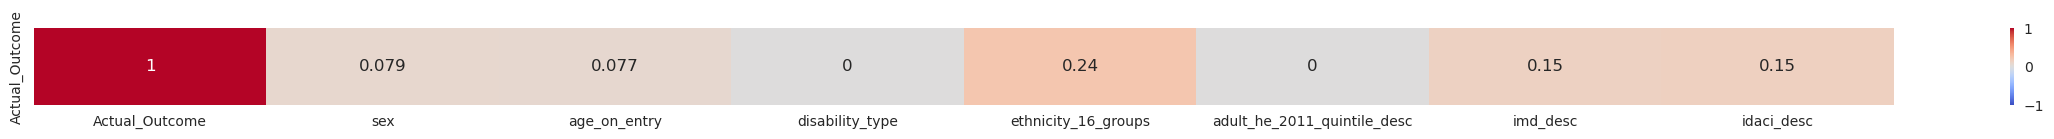

In [78]:
# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


# Load your dataframe (assuming it's already loaded as `df`)
df_selected1=combined_df_imputed[['Actual_Outcome','sex',
    'age_on_entry','disability_type','ethnicity_16_groups',
       'adult_he_2011_quintile_desc', 'imd_desc', 'idaci_desc'
    ]]

# Calculate the Cramér's V correlation matrix
cols = df_selected1.columns
cramers_v_matrix = pd.DataFrame(index=cols, columns=cols)

for col1 in cols:
    for col2 in cols:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(df_selected1[col1], df_selected1[col2])

cramers_v_matrix = cramers_v_matrix.astype(float)

# # Plot the correlation matrix using seaborn heatmap
# target_cramers_v = cramers_v_matrix
# # Plot heatmap
# plt.figure(figsize=(20, 15))  # Adjust figure size for a single row
# sns.heatmap(target_cramers_v, annot=True, cmap="coolwarm", cbar=True, vmin=-1, vmax=1)


# Plot the correlation matrix using seaborn heatmap
target_cramers_v = cramers_v_matrix.loc[['Actual_Outcome']]
# Plot heatmap
plt.figure(figsize=(30, 1))  # Adjust figure size for a single row
sns.heatmap(target_cramers_v, annot=True, cmap="coolwarm", cbar=True, vmin=-1, vmax=1)

In [79]:
# Convert the 'age_on_entry' column to string datatype to ensure consistency, possibly for categorical or text-based processing.
combined_df_imputed[['age_on_entry']] = combined_df_imputed[['age_on_entry']].astype(str)

StatementMeta(, , , Waiting, , Waiting)

**Encoding columns:** 

<u>Encoding:</u> Encoding categorical variables is a vital step in preparing data for machine learning tasks. When dealing with categorical data, characterized by non-numeric values such as text or categories, it becomes necessary to transform them into a numerical format for compatibility with machine learning algorithms.

<u>One-hot encoding:</u> This is the most widely used categorical encoding technique. It is suitable for nominal(A nominal column contains categorical data where the categories have no inherent order or ranking) categorical variables, where the categories have no inherent order or relationship. The idea behind one-hot encoding is to represent each category as a binary vector. 

_Here’s how it works_: For each category in a categorical column, a new binary column is created. The binary column will have a value of 1 if the class is present, else it will be zero.

<u>Ordinal encoding:</u> This allows to explicitly define the mapping between categories and integer labels. This is especially useful when there is a clear and predefined ordinal relationship(An ordinal relationship means that the categories of a variable have a specific order or ranking). You manually specify the order of categories and map them to integers accordingly.

Refer to this link for information on encoding concepts: https://medium.com/anolytics/all-you-need-to-know-about-encoding-techniques-b3a0af68338b


In [80]:
# Apply OrdinalEncoder to the ordinal columns
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

combined_df_imputed[['age_on_entry',
       'adult_he_2011_quintile_desc', 'imd_desc', 'idaci_desc']] = ordinal_encoder.fit_transform(combined_df_imputed[['age_on_entry',
       'adult_he_2011_quintile_desc', 'imd_desc', 'idaci_desc']])
# Apply OrdinalEncoder to the nominal columns
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')  # Do not drop any category
df_encoded = onehot_encoder.fit_transform(combined_df_imputed[['disability_type','ethnicity_16_groups','sex']])

# Create a DataFrame with the encoded data
df_encoded_df = pd.DataFrame(df_encoded, columns=onehot_encoder.get_feature_names_out(['disability_type','ethnicity_16_groups','sex']))

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded_final = pd.concat([combined_df_imputed, df_encoded_df], axis=1).drop(['disability_type','ethnicity_16_groups','sex'], axis=1)

StatementMeta(, , , Waiting, , Waiting)

In [81]:
df_encoded_final

StatementMeta(, , , Waiting, , Waiting)

,StudentNumber,age_on_entry,adult_he_2011_quintile_desc,imd_desc,idaci_desc,Concatenated_column,Actual_Outcome,Predicted_outcome_rate,Derived_progression_quintile,disability_type_Mental health condition,...,ethnicity_16_groups_Black or black British - Caribbean,ethnicity_16_groups_Mixed - other,ethnicity_16_groups_Mixed - white and Asian,ethnicity_16_groups_Mixed - white and black African,ethnicity_16_groups_Mixed - white and black Caribbean,ethnicity_16_groups_Other ethnic group,ethnicity_16_groups_Refused or unknown,ethnicity_16_groups_White,sex_Female,sex_Male
119,STU02152,5.0,4.0,3.0,3.0,Quintile 451+No disability reportedBlack or bl...,Negative,0.860000,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
604,STU06707,3.0,3.0,5.0,4.0,Quintile 331-40No disability reportedWhiteQuin...,Positive,0.830000,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1059,STU100533,4.0,1.0,1.0,2.0,Quintile 141-50No disability reportedAsian or ...,Negative,0.760000,2,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
148,STU102116,2.0,2.0,0.0,0.0,Quintile 226-30No disability reportedWhitePTMale,Positive,0.830000,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
896,STU102526,5.0,5.0,2.0,1.0,Quintile 551+No disability reportedAsian or As...,Positive,0.900000,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,STU99221,2.0,4.0,2.0,2.0,Quintile 426-30No disability reportedRefused o...,Positive,0.840000,4,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1015,STU99332,4.0,1.0,1.0,1.0,Quintile 141-50No disability reportedAsian or ...,Negative,0.840000,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1029,STU99341,4.0,1.0,1.0,2.0,Quintile 141-50No disability reportedWhiteQuin...,Negative,0.780000,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18,STU99371,3.0,3.0,3.0,3.0,Quintile 331-40Multiple or other impairmentsMi...,Positive,0.630000,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


**Dropping some columns from the dataframe**

In [82]:
df_encoded_final = df_encoded_final.drop(columns=['Concatenated_column', 'Derived_progression_quintile', 'Predicted_outcome_rate'])

StatementMeta(, , , Waiting, , Waiting)

**Displaying column names of the dataframe**

In [83]:
df_encoded_final.columns

StatementMeta(, , , Waiting, , Waiting)

Index(['StudentNumber', 'age_on_entry', 'adult_he_2011_quintile_desc',
       'imd_desc', 'idaci_desc', 'Actual_Outcome',
       'disability_type_Mental health condition',
       'disability_type_Multiple or other impairments',
       'disability_type_No disability reported',
       'disability_type_Sensory, medical or physical impairments',
       'disability_type_Social or communication impairment',
       'ethnicity_16_groups_Asian or Asian British - Indian',
       'ethnicity_16_groups_Asian or Asian British - Pakistani',
       'ethnicity_16_groups_Asian or Asian British - other',
       'ethnicity_16_groups_Black or black British - African',
       'ethnicity_16_groups_Black or black British - Caribbean',
       'ethnicity_16_groups_Mixed - other',
       'ethnicity_16_groups_Mixed - white and Asian',
       'ethnicity_16_groups_Mixed - white and black African',
       'ethnicity_16_groups_Mixed - white and black Caribbean',
       'ethnicity_16_groups_Other ethnic group',
      

**Replace the 'Positive' and 'Negative' labels in the 'Actual_Outcome' column with binary values 1 and 0, respectively.**

In [84]:
df_encoded_final['Actual_Outcome'] = df_encoded_final['Actual_Outcome'].replace({
        'Positive': 1,  
        'Negative': 0
    })

StatementMeta(, , , Waiting, , Waiting)

**Splitting data set into Training Testing and Validation set**

Training Data Definition: A dataset used to train a model. It contains input features and the corresponding output labels (for supervised learning).

Purpose: The model learns patterns, relationships, and features from this data to make predictions.

Testing Data Definition: A separate dataset used to evaluate the performance of the trained model. It should not overlap with the training data.

Purpose: To assess how well the model generalizes to unseen data, ensuring it performs well in real-world scenarios.

Process:
Data Splitting- Typically, data is split into training, validation (optional), and testing sets.
**A common split might be 70% training,20% testing and 10% validation**
Model Training: The model is trained using the training set.

Validation (if applicable): During training, the model's performance can be periodically assessed using the validation set to tune hyperparameters.

Testing: Once training is complete, the model's final performance is evaluated on the testing set to determine its accuracy, precision, recall, etc.

Importance:
Avoiding Overfitting: By keeping the testing data separate, you can avoid overfitting, where a model performs well on training data but poorly on new, unseen data.

Performance Metrics: Testing allows for the calculation of various metrics to quantify the model’s effectiveness.

**Stratified sampling** involves dividing the population (in this case, your dataset) into distinct subgroups, or "strata," based on a specific characteristic (like class labels in a classification problem). When you sample from these strata, you ensure that each class is represented proportionately in your training and testing sets.
Representation: It ensures that minority classes are adequately represented in both training and testing sets, which is crucial for building models that generalize well.
Better Performance Metrics: By maintaining the class distribution, you can calculate performance metrics (like precision, recall, and F1 score) that are more reflective of the model's true performance on the minority classes.

Reduced Bias: It helps reduce bias in the model by preventing the majority class from dominating the training process

**SMOTEEN (SMOTE + Edited Nearest Neighbors)** is a variation of the SMOTE technique specifically designed to address class imbalance in datasets while also refining the quality of the generated samples.
Purpose: SMOTEEN combines SMOTE with Edited Nearest Neighbors (ENN) to not only generate synthetic samples for the minority class but also to clean up the resulting dataset by removing noisy or redundant instances. Link to refer: https://www.geeksforgeeks.org/smote-for-imbalanced-classification-with-python/
 
This functions performs these tasks , logs the class distribution in training set testing set, whether data is imbalanced or not. this function  creates the model input data with flags of training ,tetsing and validation.
 
Business Purpose - We train the model by feeding th training data which comprises of the maximum records, then we test the model on testing data and validation data.


In [85]:
def get_train_test_validate_split(df_data_preparation):
        # # excluding unnecessary columns
        # exclude_columns = config["model_configs"][0]["exclude_columns"]
        # # exclude_columns = ['created_at']
        X = df_data_preparation

        #target_column = config["model_configs"][0]['target_column']
        target_column = 'Actual_Outcome'

        #Segregating indpendent and dependent variable.
        target= pd.DataFrame(df_data_preparation[target_column])

        y = target

        X = X.drop(columns = target_column,axis = 1)
        X_train, X_temp,y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
        X_test, X_validate,y_test,y_validate = train_test_split(X_temp, y_temp,test_size=0.4, random_state=42)
        y_train = pd.DataFrame(y_train)
        y_test = pd.DataFrame(y_test)
        y_validate = pd.DataFrame(y_validate)

        non_completion = len(y_train[y_train[target_column] == 0])
        completion = len(y_train[y_train[target_column] == 1])
        class_distribution_ratio_train = non_completion/completion

        non_completion = len(y_test[y_test[target_column] == 0])
        completion = len(y_test[y_test[target_column] == 1])
        class_distribution_ratio_test = non_completion/completion

        #     #if class ditribution in training an dtesting set is deviating by a large amount 
        #     #we do stratified sampling to split the dataset

        if (class_distribution_ratio_train-class_distribution_ratio_test)>0.05:
            
            X_train, X_temp,y_train, y_temp = train_test_split(X, y,stratify=y, test_size=0.3, random_state=42)
            X_test, X_validate,y_test,y_validate = train_test_split(X_temp, y_temp,stratify=y_temp,test_size=0.4, random_state=42)

        if (round(class_distribution_ratio_train,2) < 0.7): 
            #if minority class ie, discontinued is too low than majority class check)
            #using oversampling technique like SMOTEENN (Synthetic Minority Over-sampling Technique) to balance the training dataset
            
            X_train_without_id = X_train.drop(columns = 'StudentNumber',axis = 1)
            #X_train_without_id = X_train.drop(columns = ['Student_Code'],axis = 1)
            
            #fitting smoteen
            sme = SMOTEENN(random_state=42)
            X_resampled, y_resampled  = sme.fit_resample(X_train_without_id, y_train)  
            y_resampled['data_flag']='Training_Set'

            # X_resampled = pd.concat([X_resampled,X_test])
            # y_resampled = pd.concat([y_resampled,y_test])
            
            resampled_data = pd.concat([X_resampled,y_resampled],axis=1)

            non_completion_resampled = len(resampled_data[resampled_data[target_column] == 0])
            completion_resampled = len(resampled_data[resampled_data[target_column] == 1])

            #class distribution ratio of resampled data

            class_distribution_ratio_resampled = non_completion_resampled/completion_resampled
            

            # #copying all dataframes to create final dataframe
            X_test1 = X_test.copy()
            X_validate1= X_validate.copy()
            
            y_test1 = y_test.copy()
            y_validate1 = y_validate.copy() 

            y_test1['data_flag'] = 'Test_Set'
            y_validate1['data_flag'] = 'Validation_Set'

            dataframes1 = [X_resampled, X_test1,X_validate1]
            dataframes2 = [y_resampled, y_test1,y_validate1]
            # Append all DataFrames

            split_table_p = pd.DataFrame()
            split_X_table = pd.concat(dataframes1, ignore_index=True)
            split_y_table = pd.concat(dataframes2, ignore_index=True)
            split_table_p = pd.concat([split_X_table,split_y_table],axis = 1)

            #create the final table with flags of training,testing,validation

            split_table_p = split_table_p.loc[:, ~split_table_p.columns.duplicated()]  

        else:
            
            # #copying all dataframes to create final dataframe
            X_train1 = X_train.copy()
            X_test1 = X_test.copy()
            X_validate1= X_validate.copy()
            y_train1= y_train.copy()
            y_test1 = y_test.copy()
            y_validate1 = y_validate.copy()

            # data_flag of training,test and validation
            y_train1['data_flag'] = 'Training_Set'
            y_test1['data_flag'] = 'Test_Set'
            y_validate1['data_flag'] = 'Validation_Set'

            dataframes1 = [X_train1, X_test1,X_validate1]
            dataframes2 = [y_train1, y_test1,y_validate1]
            # Append all DataFrames

            split_table_p = pd.DataFrame()
            split_X_table = pd.concat(dataframes1, ignore_index=True)
            split_y_table = pd.concat(dataframes2, ignore_index=True)
            split_table_p = pd.concat([split_X_table,split_y_table],axis = 1)

            #create the final table with flags of training,testing,validation

            split_table_p = split_table_p.loc[:, ~split_table_p.columns.duplicated()]
 
        return split_table_p

StatementMeta(, , , Waiting, , Waiting)

**This function performs training on a logistic regression model using GridSearchCV for hyperparameter tuning. It evaluates different penalty types, regularization strengths (C), and solvers to find the best model configuration using 5-fold cross-validation. The function returns the best estimator after fitting the model to the training data.**

In [86]:
def model_training(X_train, y_train):
    # Initialize the model
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=42, max_iter=1000)

    # Define the hyperparameters you want to tune
    param_grid = {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        #'penalty': ['elasticnet'],
        'C': [0.1, 1, 10],
        # 'solver': ['liblinear', 'saga', 'lbfgs']
        'solver': ['liblinear', 'newton-cholesky', 'lbfgs','saga']
    }

    # Set up the GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)

    # Fit the model
    grid_search.fit(X_train, y_train)

    return(grid_search.best_estimator_)

StatementMeta(, , , Waiting, , Waiting)

**The _calculate_metrics_ function evaluates the performance of a classification model by computing key metrics: accuracy, precision, recall, and probability of Type I error (False Positive Rate). It also generates a confusion matrix to understand the distribution of predicted versus actual labels. For multi-class scenarios, the metrics are weighted to account for class imbalances. This function provides a comprehensive evaluation of the model's performance across different dimensions.**

In [87]:
def calculate_metrics(y_true, y_pred):
        # Accuracy
        accuracy = accuracy_score(y_true, y_pred)
        
        # Precision (using 'macro' for multiple classes, adjust if necessary)
        precision = precision_score(y_true, y_pred, average='weighted')
        
        # Recall (using 'macro' for multiple classes, adjust if necessary)
        recall = recall_score(y_true, y_pred, average='weighted')
        
        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate probability of Type I Error (False Positive Rate)
        # Here, Type I error is calculated as the ratio of false positives to total negatives
        # FPR for each class; adjust based on specific requirements for multiclass scenario
        
        false_positive_rate = cm.sum(axis=0) - np.diag(cm)
        total_negatives = cm.sum(axis=0)
        prob_type1_error = (false_positive_rate / total_negatives).mean()  # Average for all classes
        
        return accuracy, precision, recall, prob_type1_error

StatementMeta(, , , Waiting, , Waiting)

**Plotting Confusion matrix**

In [88]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(title)
        plt.show()

StatementMeta(, , , Waiting, , Waiting)

**The _generate_local_explanation_ function uses the LIME (Local Interpretable Model-Agnostic Explanations) framework to provide interpretability for individual model predictions. It initializes a LimeTabularExplainer with training data, feature names, and class labels. The function then selects a random instance from the test set and generates an explanation for its prediction, highlighting the top contributing features.**

In [89]:
def generate_local_explanation(X_train, X_test):
        explainer = LimeTabularExplainer(
                X_train.values,
                feature_names=X_train.columns,
                class_names=[0.0, 1.0, 2.0],  # Adjust based on your class labels
                discretize_continuous=False
                )
        
        explainer_params = {
            'train_data': X_train.values,
            'feature_names': X_train.columns.tolist(),
            'class_names': [0.0, 1.0, 2.0],
            'discretize_continuous': False
        }


        # Explain a single prediction using LIME
        instance = random.randint(1,5) # Index of the instance from test set to explain

        #logging(LogLevel.INFO.value,f"Local Explanability for instance from testing set with Continuation flag(Positive-2,Neutral-1,Negative-0) :{test_data[config['ID']].iloc[instance],y_true_test.iloc[instance]}")
        exp = explainer.explain_instance(X_test.iloc[instance].values, model.predict_proba, num_features=5,top_labels =3)

        # Step 8: Visualize the explanation for the predicted class

        exp.show_in_notebook(show_table=True)

StatementMeta(, , , Waiting, , Waiting)

In [90]:
df_encoded_final

StatementMeta(, , , Waiting, , Waiting)

,StudentNumber,age_on_entry,adult_he_2011_quintile_desc,imd_desc,idaci_desc,Actual_Outcome,disability_type_Mental health condition,disability_type_Multiple or other impairments,disability_type_No disability reported,"disability_type_Sensory, medical or physical impairments",...,ethnicity_16_groups_Black or black British - Caribbean,ethnicity_16_groups_Mixed - other,ethnicity_16_groups_Mixed - white and Asian,ethnicity_16_groups_Mixed - white and black African,ethnicity_16_groups_Mixed - white and black Caribbean,ethnicity_16_groups_Other ethnic group,ethnicity_16_groups_Refused or unknown,ethnicity_16_groups_White,sex_Female,sex_Male
119,STU02152,5.0,4.0,3.0,3.0,0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
604,STU06707,3.0,3.0,5.0,4.0,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1059,STU100533,4.0,1.0,1.0,2.0,0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
148,STU102116,2.0,2.0,0.0,0.0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
896,STU102526,5.0,5.0,2.0,1.0,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,STU99221,2.0,4.0,2.0,2.0,1,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1015,STU99332,4.0,1.0,1.0,1.0,0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1029,STU99341,4.0,1.0,1.0,2.0,0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18,STU99371,3.0,3.0,3.0,3.0,1,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


**Calling 'get_train_test_validate_split' function**

In [91]:
# Labelling train, test and validation dataset

df_model_train_test_validate_data = get_train_test_validate_split(df_encoded_final)

StatementMeta(, , , Waiting, , Waiting)

**The code splits the dataset into training, test, and validation sets based on the data_flag column, which indicates the type of data. It then separates the target column (Actual_Outcome) from the feature columns for each data set (training, test, and validation). Additionally, it drops irrelevant columns such as StudentNumber and data_flag from the feature set before creating the training, test, and validation feature sets (X_train, X_test, and X_validation). These steps prepare the data for model training and evaluation.**

In [92]:
# Defining train test and validation data
train_data = df_model_train_test_validate_data[df_model_train_test_validate_data['data_flag']=='Training_Set']
test_data = df_model_train_test_validate_data[df_model_train_test_validate_data['data_flag']=='Test_Set']
validation_data = df_model_train_test_validate_data[df_model_train_test_validate_data['data_flag']=='Validation_Set']


target_column = "Actual_Outcome"

# Splitting Train Data
y_train = train_data[target_column]

X_train = train_data.drop(columns = target_column,axis = 1)
X_train = X_train.drop(columns=['StudentNumber', 'data_flag'], axis=1)


# Splitting Test Data
y_test = test_data[target_column]

X_test = test_data.drop(columns = target_column,axis = 1)
X_test = X_test.drop(columns=['StudentNumber', 'data_flag'], axis=1)


# Splitting Validation Data
y_validation = pd.DataFrame(validation_data[target_column])

X_validation = validation_data.drop(columns = target_column,axis = 1)
X_validation = X_validation.drop(columns=['StudentNumber', 'data_flag'], axis=1)

StatementMeta(, , , Waiting, , Waiting)

**It begins model training by invoking the model_training function with the training data. After training the model, it makes predictions on both the training and testing data. The model's performance is then evaluated using the calculate_metrics function, which calculates accuracy, precision, recall, and the probability of Type I error for both training and testing datasets. This provides insights into the model's effectiveness on both the training and test data, helping assess its generalization ability.**

In [93]:
# Model training begins
model = model_training(X_train, y_train)

# Predictions on training data
y_train_pred = model.predict(X_train)
#y_train_pred_proba = model.predict_proba(X_train)  # For probabilities, if needed

# Evaluating model performance on training data
train_accuracy, train_precision, train_recall, train_prob_type1_error = calculate_metrics(y_train, y_train_pred)

# Predictions on testing data
y_test_pred = model.predict(X_test)
#y_test_pred_proba = model.predict_proba(X_test)  # For probabilities, if needed

# Evaluating model performance on training data
test_accuracy, test_precision, test_recall, test_prob_type1_error = calculate_metrics(y_test, y_test_pred)

StatementMeta(, , , Waiting, , Waiting)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

**Displaying performance of the model**

In [95]:
print("Train Metric : ", train_accuracy, train_precision, train_recall, train_prob_type1_error)
print("Test Metric : ", test_accuracy, test_precision, test_recall, test_prob_type1_error)

StatementMeta(, , , Waiting, , Waiting)

Train Metric :  0.7567567567567568 0.7547864879325554 0.7567567567567568 0.24824772605671483
Test Metric :  0.47580645161290325 0.591969511365183 0.47580645161290325 0.4735583684950773


**Calling the above function and displaying confusion matrix**

StatementMeta(, , , Waiting, , Waiting)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

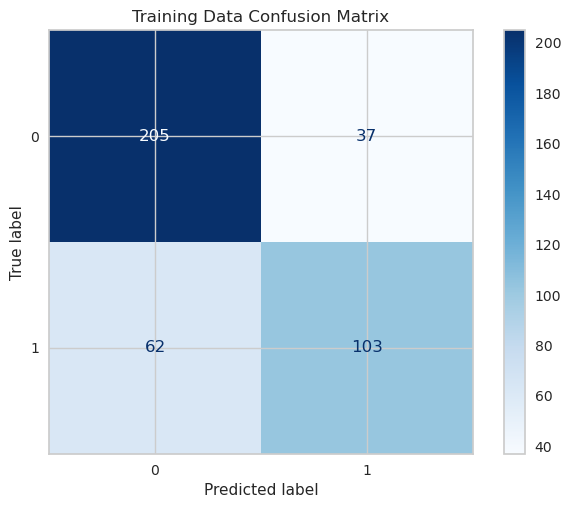

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

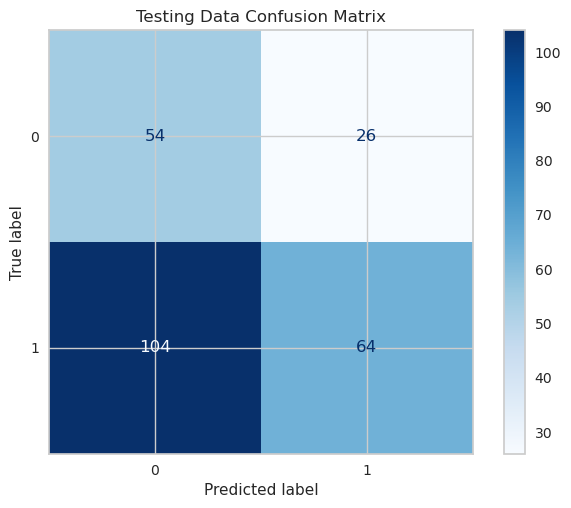

In [97]:
# Plot confusion matrix for training predictions
plot_confusion_matrix(y_train, y_train_pred, title="Training Data Confusion Matrix")

# Plot confusion matrix for testing predictions
plot_confusion_matrix(y_test, y_test_pred, title="Testing Data Confusion Matrix")


**Displaying feature importance plot**

StatementMeta(, , , Waiting, , Waiting)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

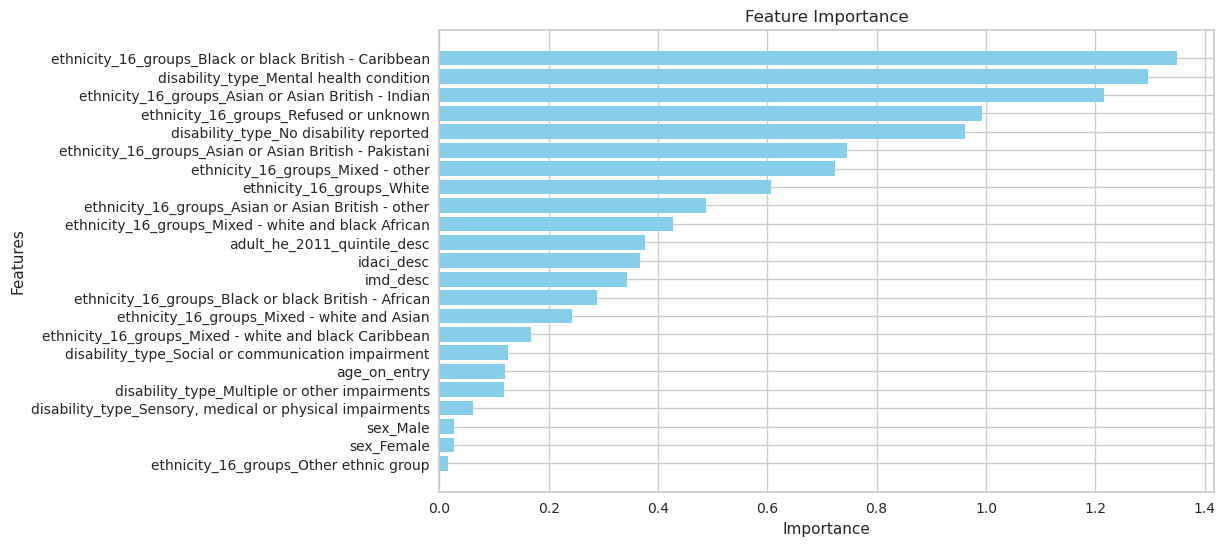

In [98]:
# Extract feature importance using model coefficients
feature_importances = model.coef_[0]  # For multiclass, use model.coef_ as a matrix
feature_names = [i for i in X_train.columns]

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': abs(feature_importances)  # Take absolute values for magnitude comparison
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance on top
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

**Noting down models' global explanability.**

**Global explanability**  of a model refers to understanding how a machine learning model makes decisions across the entire dataset, rather than just for individual predictions. This involves analyzing the relationships between input features and the output predictions to gain insights into the model's behavior. Identifying influential features in a model is crucial for understanding its behavior and improving its performance. Here’s a deeper dive into two popular techniques:
Permutation Importance and **SHAP (SHapley Additive exPlanations) values** .It calculates the average contribution of each feature to the model's output across all possible combinations of features.
For a given prediction, **SHAP values** calculate how much each feature contributes to the difference between the model's output and the average prediction.
The contributions from all features sum up to the model's prediction, ensuring consistent and fair attribution. We have used  to build global explanability graph **shap.summary plot** for models except catboost we have used inbuilt function of pycaret interpret_model , the underlying process is same for both the functions.

Ref: https://www.geeksforgeeks.org/shap-a-comprehensive-guide-to-shapley-additive-explanations/
https://www.geeksforgeeks.org/introduction-to-explainable-aixai-using-lime/


StatementMeta(, , , Waiting, , Waiting)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

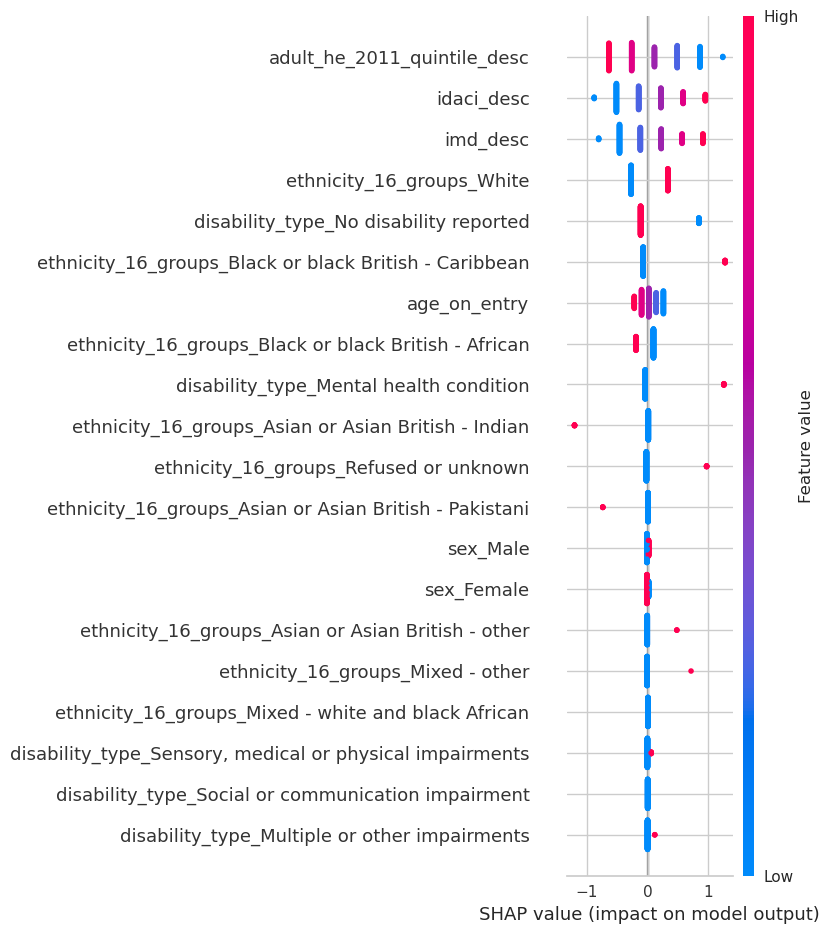

In [99]:
import shap

# Assuming 'model' is your trained LogisticRegression model
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

# Generate the summary plot
shap.summary_plot(shap_values, X_test, show=True)


**This step processes SHAP (Shapley Additive Explanations) values for each class and creates individual DataFrames for each class's SHAP values, including the sample index and class label. These DataFrames are concatenated into a single DataFrame (shap_summary_df) that contains the SHAP values for all classes. The global feature importance is calculated by averaging the absolute SHAP values for each feature across all classes, resulting in a summary table (feature_importance_df) that ranks features based on their importance across all classes.**

In [100]:
import pandas as pd

# Assuming 'shap_values' is a list of arrays, one for each class
shap_dfs = []

for i, class_shap_values in enumerate(shap_values):
    # Check if class_shap_values is 2D
    if len(class_shap_values.shape) == 2 and class_shap_values.shape[1] == len(X_test.columns):
        # Create a DataFrame from the SHAP values
        shap_df = pd.DataFrame(class_shap_values, columns=X_test.columns)
        shap_df.insert(0, 'Sample', X_test.index)  # Add sample index for reference
        shap_df['Class'] = i  # Label the class
        shap_dfs.append(shap_df)
    else:
        print(f"Shape mismatch or unexpected shape for class {i}: {class_shap_values.shape}")

# Combine all class-specific DataFrames if any were created
if shap_dfs:
    combined_shap_df = pd.concat(shap_dfs)
    print(combined_shap_df)
else:
    print("No SHAP values were processed due to shape mismatches.")

StatementMeta(, , , Waiting, , Waiting)

Shape mismatch or unexpected shape for class 0: (23,)
Shape mismatch or unexpected shape for class 1: (23,)
Shape mismatch or unexpected shape for class 2: (23,)
Shape mismatch or unexpected shape for class 3: (23,)
Shape mismatch or unexpected shape for class 4: (23,)
Shape mismatch or unexpected shape for class 5: (23,)
Shape mismatch or unexpected shape for class 6: (23,)
Shape mismatch or unexpected shape for class 7: (23,)
Shape mismatch or unexpected shape for class 8: (23,)
Shape mismatch or unexpected shape for class 9: (23,)
Shape mismatch or unexpected shape for class 10: (23,)
Shape mismatch or unexpected shape for class 11: (23,)
Shape mismatch or unexpected shape for class 12: (23,)
Shape mismatch or unexpected shape for class 13: (23,)
Shape mismatch or unexpected shape for class 14: (23,)
Shape mismatch or unexpected shape for class 15: (23,)
Shape mismatch or unexpected shape for class 16: (23,)
Shape mismatch or unexpected shape for class 17: (23,)
Shape mismatch or un

**Noting down models' local explanability.**

**Local explainability** focuses on understanding individual predictions made by a machine learning model. One popular technique for achieving this is LIME (Local Interpretable Model-agnostic Explanations).
 
Local Focus: By focusing on individual predictions,**LIME** provides insights tailored to specific instances rather than the overall model..
this block runs all intermediate steps and errors if any in the final_logs table in silver layer with respective timestamp and from which block which notebook the errors has appeared. 
Ref: https://www.geeksforgeeks.org/shap-a-comprehensive-guide-to-shapley-additive-explanations/
https://www.geeksforgeeks.org/introduction-to-explainable-aixai-using-lime/

In [101]:
generate_local_explanation(X_train, X_test)

StatementMeta(, , , Waiting, , Waiting)